<a href="https://colab.research.google.com/github/gchn24/DS-Notes/blob/main/YuluBusinessCaseReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement:

In [8]:
# Importing required libraries -
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind # T-test for independent samples
from scipy.stats import shapiro # Shapiro-Wilk’s test for Normality
from scipy.stats import levene # Levene's test for Equality of Variance
from scipy.stats import f_oneway # One-way ANOVA
from scipy.stats import chi2_contingency # Chi-square test of independence
# from scipy.stats import kstest # KS test for Normality

In [9]:
import warnings
warnings.simplefilter('ignore')

In [10]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1ZpORKGL4HpjAB_H7F0l7DNddKEUCZHF3/view?usp=sharing'

id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('yulu_data.csv')

In [11]:
# Loading the dataset -
df=pd.read_csv('yulu_data.csv')
df.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
9385,2012-09-14 10:00:00,3,0,1,2,27.88,31.820,65,0.0000,75,171,246
5078,2011-12-05 16:00:00,4,0,1,1,20.50,24.240,63,6.0032,10,238,248
10219,2012-11-11 05:00:00,4,0,0,1,12.30,15.150,87,8.9981,0,12,12
1688,2011-04-16 06:00:00,2,0,0,3,16.40,20.455,82,22.0028,1,9,10
7232,2012-04-19 17:00:00,2,0,1,1,24.60,31.060,43,6.0032,85,663,748
7453,2012-05-09 22:00:00,2,0,1,3,19.68,23.485,82,7.0015,5,62,67
6382,2012-03-03 04:00:00,1,0,0,2,14.76,17.425,93,12.9980,0,2,2
216,2011-01-10 07:00:00,1,0,1,1,4.92,6.060,50,15.0013,2,75,77
10675,2012-12-11 05:00:00,4,0,1,3,13.94,15.150,71,22.0028,1,40,41
10810,2012-12-16 20:00:00,4,0,0,2,15.58,19.695,82,0.0000,14,108,122


In [12]:
# Shape of the dataset -
print("No. of rows : ", df.shape[0])

No. of rows :  10886


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [14]:
# Checking for null values -
(df.isna().sum() / len(df)) * 100

datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

In [15]:
# Checking for duplicate rows -
dup_rows = df[df.duplicated()]
print("No. of duplicate rows: ", dup_rows.shape[0])

No. of duplicate rows:  0


In [16]:
def dist_check(df, col_name):
  print("Unique values : ", df[col_name].unique())
  print("Value counts : ")
  print(df[col_name].value_counts())

In [17]:
col_list = ['workingday',	'holiday',	'weather', 'season']
for col in col_list:
  print(col, " -")
  dist_check(df, col)
  print("\n")

workingday  -
Unique values :  [0 1]
Value counts : 
1    7412
0    3474
Name: workingday, dtype: int64


holiday  -
Unique values :  [0 1]
Value counts : 
0    10575
1      311
Name: holiday, dtype: int64


weather  -
Unique values :  [1 2 3 4]
Value counts : 
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


season  -
Unique values :  [1 2 3 4]
Value counts : 
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64




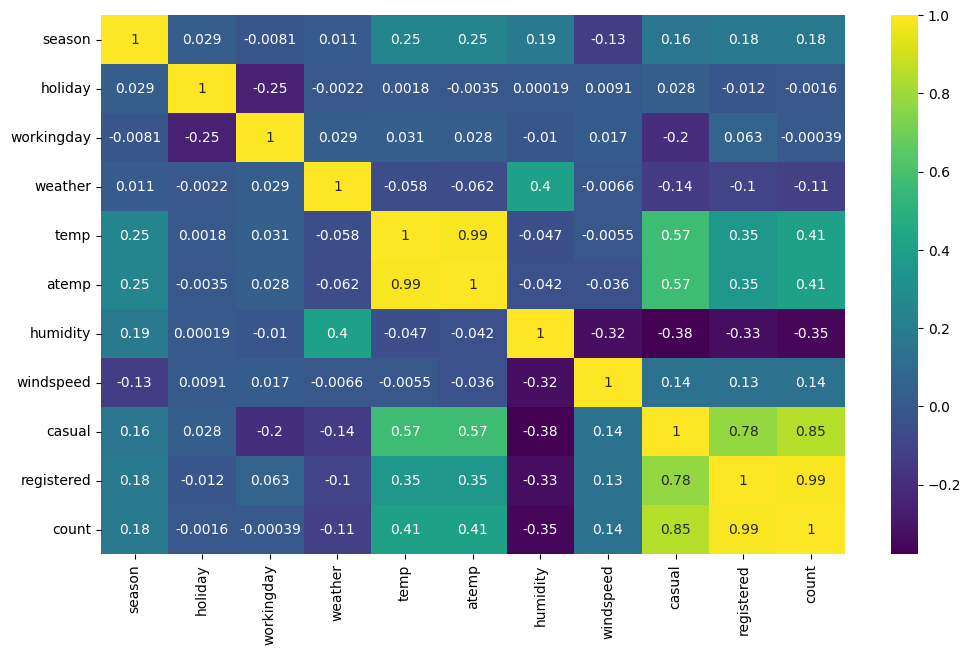

In [18]:
# Correlation Heatmap -

plt.figure(figsize=(12, 7))
sbn.heatmap(df.corr(method='spearman'),
            annot=True, cmap='viridis')
plt.show()
#HW - understand basic usecase of spearman and pearson

from the correlation we can verify some logical points:
- feeling temperature or aparent temprature and temp are highly correlated, because they are most of the times approximately the same have a very small diffrerence
- count, causal, registered are all correlated to each other because all of them are linked as per: causal + registered = count

In [19]:
# Dropping highly correlated columns -
dfn = df.drop(columns=['casual', 'registered', 'atemp'])

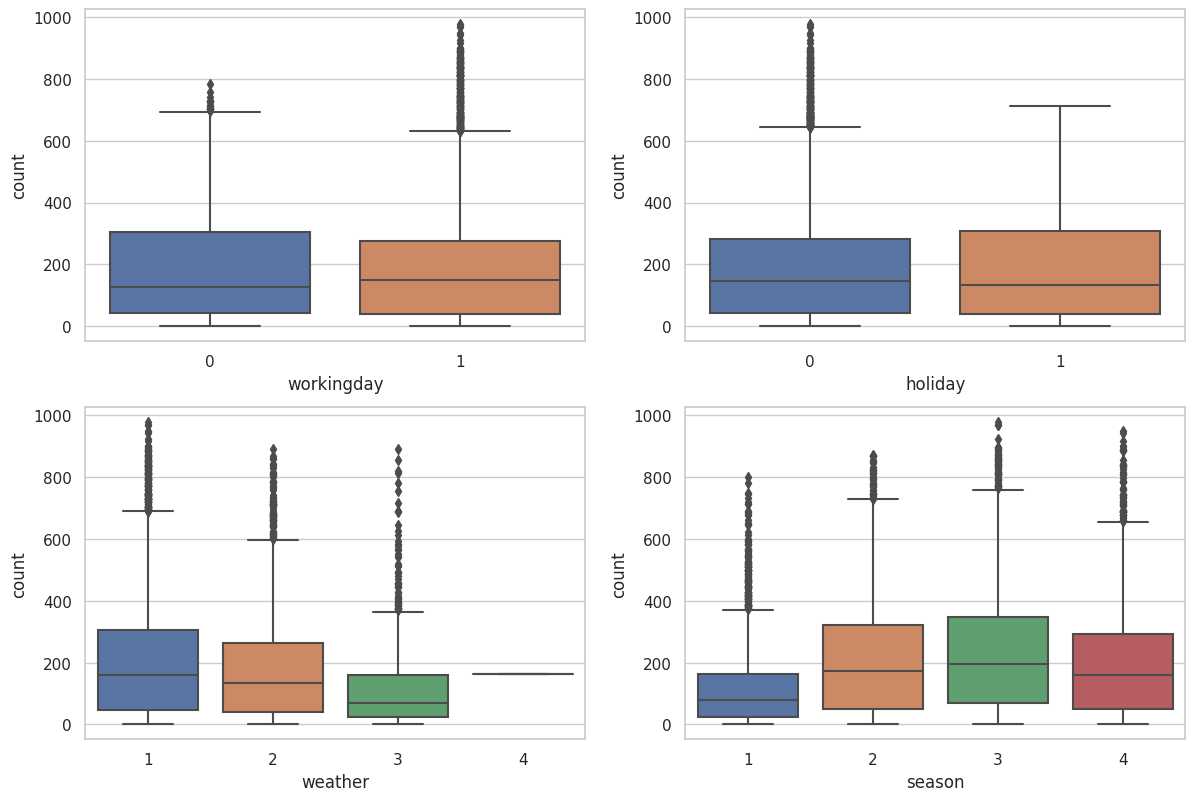

In [20]:
# Outlier Detection using Boxplots -

sbn.set(style="whitegrid")
fig = plt.figure(figsize=(8, 25))
fig.subplots_adjust(right=1.5)

for plot in range(1, len(col_list)+1):
    plt.subplot(5, 2, plot)
    sbn.boxplot(x=dfn[col_list[plot-1]], y=dfn['count'])

plt.show()

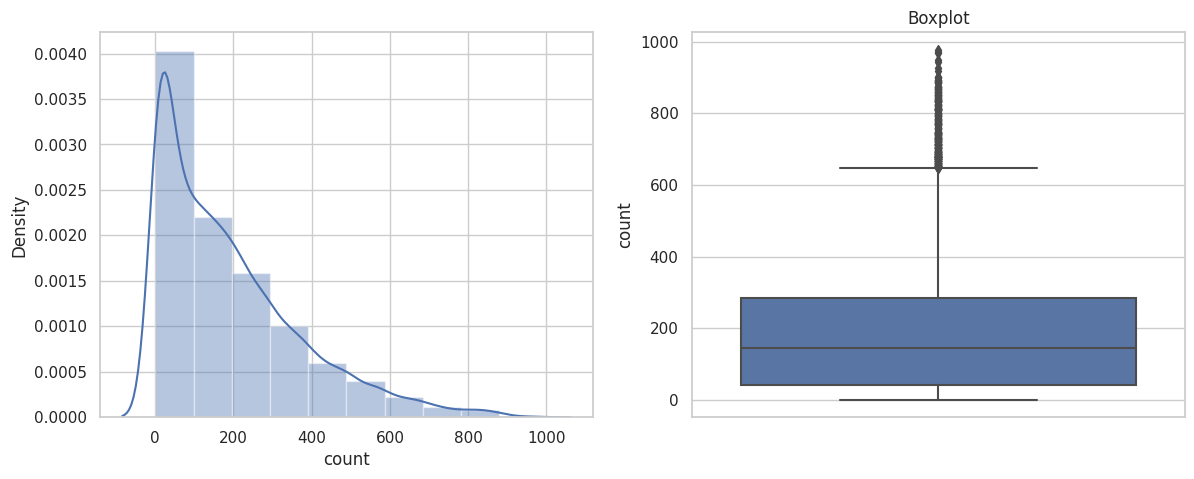

In [21]:
# Checking distribution of 'count' column -
plt.figure(figsize=(14, 5))

#Histogram
plt.subplot(1, 2, 1)
sbn.distplot(dfn['count'], bins=10)

#Boxplot
plt.subplot(1, 2, 2)
sbn.boxplot(y=dfn['count'])
plt.title('Boxplot')

plt.show()

We can see that outliers are present in the given columns. We need to figure out a way to deal with them before starting with the tests.

We have multiple options available on how to proceed with these outlier values.

1. Try to understand if these values make any sense according to the business problem. If yes, then we can keep them as it is.
2. In case these outliers are some invalid values which do not make much sense, we can remove them using the IQR.
3. Or we can apply a log transformation on the data to reduce the effect of these outliers.

1. -
* The outliers in the given data set are the no. of bike rides per session/day. These values could sometimes be higher than expected due to increase in the crowd on certain days/occasions.
* These data values are important for capturing variations in the data. Hence, in this case, the ideal approach of dealing with outliers would be to leave them as it is.
* But since the tests that we are going to apply are based on the assumption that the dataset is normal or near normal, we will drop those outlier values using the IQR method.

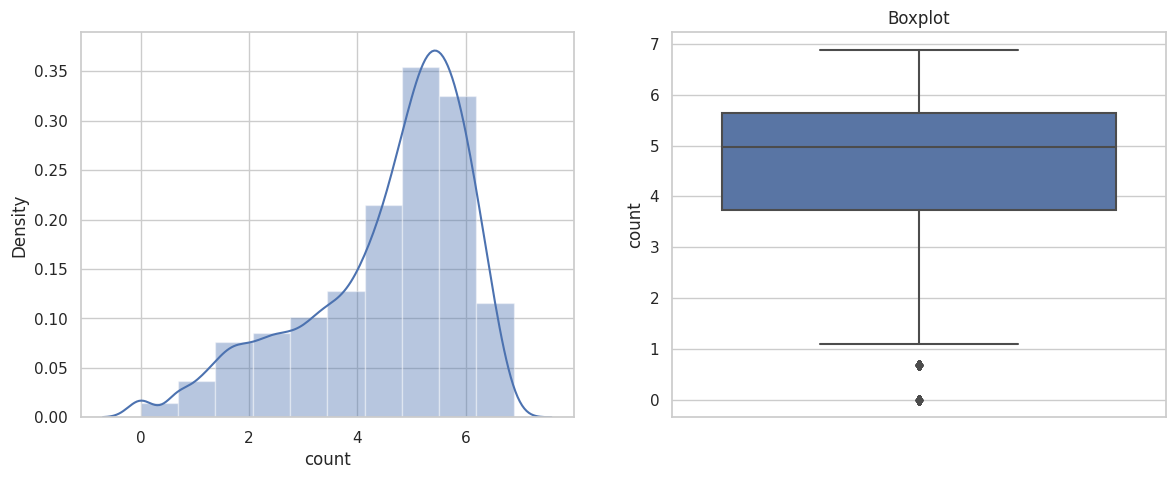

In [22]:
# 2.
# Checking distribution after applying log transformation -
plt.figure(figsize=(14, 5))

#Histogram
plt.subplot(1, 2, 1)
sbn.distplot(np.log(dfn['count']), bins=10)

#Boxplot
plt.subplot(1, 2, 2)
sbn.boxplot(y=np.log(dfn['count']))
plt.title('Boxplot')

plt.show()

In [23]:
# # 3.
# # Outlier Treatment using IQR (not needed but, we can do it) -

# q1 = dfn['count'].quantile(0.25)
# q3 = dfn['count'].quantile(0.75)
# iqr = q3-q1

# dfn = dfn[(dfn['count']>(q1-1.5*iqr) ) & (dfn['count']<(q3+1.5*iqr))]

# print("No. of rows : ", dfn.shape[0])

#### Aggregating the total no. of bike rides based on the given factors -

In [24]:
# 1. Workingday -
pd.DataFrame(dfn.groupby('workingday')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


In [25]:
# 2. Holiday -
pd.DataFrame(dfn.groupby('holiday')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
holiday,,,,,,,,
0,10575.0,191.741655,181.513131,1.0,43.0,145.0,283.0,977.0
1,311.0,185.877814,168.300531,1.0,38.5,133.0,308.0,712.0


In [26]:
# 3. Season -
pd.DataFrame(dfn.groupby('season')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


In [27]:
# 4. Weather -
pd.DataFrame(dfn.groupby('weather')['count'].describe())

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,205.236791,187.959566,1.0,48.0,161.0,305.0,977.0
2,2834.0,178.955540,168.366413,1.0,41.0,134.0,264.0,890.0
3,859.0,118.846333,138.581297,1.0,23.0,71.0,161.0,891.0
4,1.0,164.000000,NaN,164.0,164.0,164.0,164.0,164.0


---



### Ques. 1 - Is there any significant difference between the no. of bike rides on weekdays and weekends?
---

#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ The demand of bikes on weekdays is greater or similar to the demand of bikes on weekend.

$H_a:$ The demand of bikes on weekdays is less than the demand of bikes on weekend.

Let $\mu_1$ and $\mu_2$ be the average no. of bikes rented on weekdays and weekends respectively.

Mathematically, the above formulated hypothesis can be written as:

$H_0: \mu_1 >= \mu_2$

$H_a: \mu_1 < \mu_2$

**Ques.** What is the difference between a t-test and a z-test?

**Ans.**

* A t-test looks at two sets of data that are different from each other, with no standard deviation or variance.

* A z-test views the averages of data sets that are different from each other but have the standard deviation or variance given.

* The t test as compared with z test has its advantage for small sample comparison. As n increases, t approaches to z. The advantage of t test disappears, and t distribution simply becomes z distribution.

* In other words, with large n, t test is just close to z test and one doen't lose anything to continue to use t test.

* In the past, for convenience, we use z table when n > 30.  We don't have to do it anymore.

* In fact, all statistical packages use t test even n is large. This is easy, convenience with computer programming, and is correct. All statistical packages are good references.

#### **Step 2:** Select an appropriate test

Note that the standard deviation of the population is not known.

In [28]:
weekday = dfn[dfn['workingday'] == 1]['count'].sample(2999)
weekend = dfn[dfn['workingday'] == 0]['count'].sample(2999)

**Ques.** Why do we take same no. of samples from two different populations for conducting the tests?

**Ans.**
* Unequal sample sizes can lead to unequal variances between samples, which affects the assumption of equal variances in tests like t-test, ANOVA, etc.

* Having both unequal sample sizes and variances dramatically affects the statistical power of a test.


In [29]:
print('The sample standard deviation of the bike rides on weekday is:', round(weekday.std(), 2))
print('The sample standard deviation of the bike rides on weekend is:', round(weekend.std(), 2))

The sample standard deviation of the bike rides on weekday is: 181.32
The sample standard deviation of the bike rides on weekend is: 174.76


As the sample standard deviations are different, the population standard deviations can be assumed to be different.

This is a one-tailed test concerning two population means from two independent populations. As the population standard deviations are unknown, the two sample independent t-test will be the appropriate test for this problem.

#### **Step 3:** Decide the significance level

As given in the problem statement, we select α = 0.05.

In [30]:
alpha = 0.05

#### **Step 4:** Calculate the p-value

In [31]:
def result(p_value, alpha):
  if p_value < alpha:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
  else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

In [32]:
test_stat, p_value = ttest_ind(weekday, weekend, equal_var=False, alternative='less')
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  0.49311566509575255
As the p-value 0.49311566509575255 is greater than the level of significance, we fail to reject the null hypothesis.


**Observation:** Since the p-value is greater than the 5% significance level, we fail to reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides during weekdays is greater than or equal to those on weekends.

---
### Ques. 2 - Is there any significant difference between the no. of bike rides on regular days and holidays?
---

#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ The demand of bikes on regular days is greater or similar to the demand of bikes on holidays.

$H_a:$ The demand of bikes on regular days is less than the demand of bikes on holidays.

Let $\mu_1$ and $\mu_2$ be the average no. of bikes rented on regular days and holidays respectively.

Mathematically, the above formulated hypothesis can be written as:

$H_0: \mu_1 >= \mu_2$

$H_a: \mu_1 < \mu_2$

#### **Step 2:** Select an appropriate test

Again the standard deviation of the population is not known.

In [33]:
holiday = dfn[dfn['holiday'] == 1]['count'].sample(299)
regular = dfn[dfn['holiday'] == 0]['count'].sample(299)

In [34]:
print('The sample standard deviation of the bike rides on holidays is:', round(holiday.std(), 2))
print('The sample standard deviation of the bike rides on regular days is:', round(regular.std(), 2))

The sample standard deviation of the bike rides on holidays is: 169.5
The sample standard deviation of the bike rides on regular days is: 191.62


As the sample standard deviations are different, the population standard deviations can be assumed to be different.

This is also a one-tailed test concerning two population means from two independent populations. As the population standard deviations are unknown, the two sample independent t-test will be the appropriate test for this problem.

#### **Step 3:** Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

#### **Step 4:** Calculate the p-value

In [35]:
test_stat, p_value = ttest_ind(regular, holiday, equal_var=False, alternative='less')
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  0.9095171358199248
As the p-value 0.9095171358199248 is greater than the level of significance, we fail to reject the null hypothesis.


**Observation:** Since the p-value is greater than the 5% significance level, we fail to reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides during regular days is greater than or equal to those on holidays.

---
### Ques. 3 - Is the demand of bicycles on rent same for different weather conditions?
---

#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ The average no. of bike rides in different weather conditions  are equal.

$H_a:$ The average no. of bike rides in different weather conditions are not equal.

Let $\mu_1$ and $\mu_2$ be the average no. of bikes rented on weekdays and weekends respectively.

#### **Step 2:** Select an appropriate test


In [36]:
dfn = dfn[~(dfn['weather']==4)]

In [37]:
w1 = dfn[dfn['weather'] == 1]['count'].sample(750)
w2 = dfn[dfn['weather'] == 2]['count'].sample(750)
w3 = dfn[dfn['weather'] == 3]['count'].sample(750)

In [38]:
dfn.groupby(['weather'])['count'].describe()

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,205.236791,187.959566,1.0,48.0,161.0,305.0,977.0
2,2834.0,178.955540,168.366413,1.0,41.0,134.0,264.0,890.0
3,859.0,118.846333,138.581297,1.0,23.0,71.0,161.0,891.0


This is a problem, concerning three independent population means. **One-way ANOVA** could be the appropriate test here provided normality and equality of variance assumptions are verified.

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

* The samples are independent.
* Each sample is from a normally distributed population.
* The population variance of the groups are all equal.

Now, we will be using the following statistical tests to check the normality and euality of variance of the data set -

* For testing of normality, Shapiro-Wilk’s test is applied to the response variable.

* For equality of variance, Levene test is applied to the response variable.

#### Shapiro-Wilk’s test -

We will test the null hypothesis

>$H_0:$ Count follows normal distribution

against the alternative hypothesis

>$H_a:$ Count doesn't follow normal distribution



In [39]:
# Assumption 1: Normality

w, p_value = shapiro(dfn['count'].sample(4999))
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  0.0
As the p-value 0.0 is less than the level of significance, we reject the null hypothesis.


#### Levene’s test -

We will test the null hypothesis

>$H_0$: All the count variances are equal

against the alternative hypothesis

>$H_a$: At least one variance is different from the rest

In [40]:
#Assumption 2: Homogeneity of Variance

stat, p_value = levene(w1, w2, w3)
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  6.733445330797891e-21
As the p-value 6.733445330797891e-21 is less than the level of significance, we reject the null hypothesis.


**Note:** If these assumptions are not true for a given set of data (like in this case), it may still be possible to use the **Kruskal-Wallis H-test** or the **Alexander-Govern test** although with some loss of power.

### Central Limit Theorem -

You all must have studies about the CLT in previous classes.

* According to this theorem, the distribution of sample means approximates a normal distribution as the sample size gets larger, regardless of the population's distribution.

* In other words, if we find the mean of a large number of independent random variables, the mean
will follow a normal distribution, irrespective of the distribution of the original variables.

* In practice, sample sizes equal to or greater than 30-40 are often considered sufficient for the CLT to hold.

Hence, the sample size being large enough, we don't need to worry about the non-normality of distribution of the data set in hand before applying the tests.

Eventually, as the sample size gets larger, the distribution of sample means will fall into a normal or near normal shape.


**Ques.** What are some of the basic methods (other than statistical tests) to test the normality & homogeneity of variance?

A. To check for **Normality -**

<Axes: xlabel='count', ylabel='Density'>

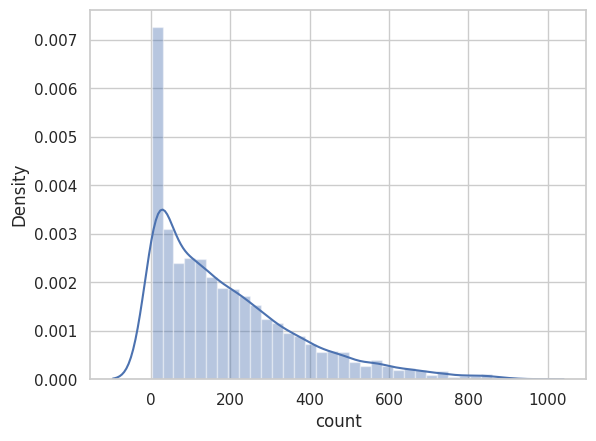

In [41]:
# Method 1: Using a Histogram
# You should see a 'Bell' shaped curve.
sbn.distplot(dfn['count'].sample(4999))

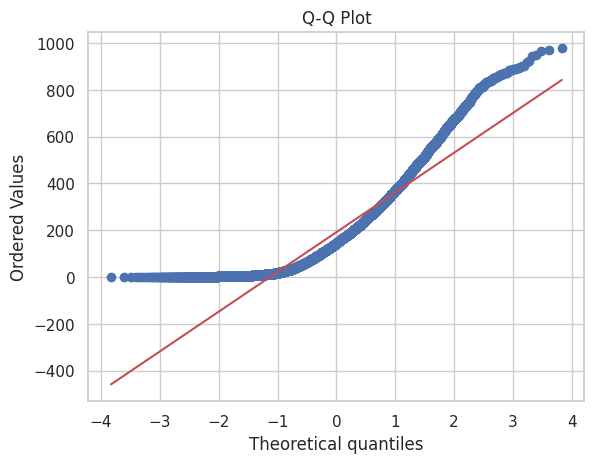

In [42]:
# Method 2: Using a Q-Q plot
# The linearity of points suggests that the data is normally distributed.
stats.probplot(dfn['count'], dist='norm', fit=True, plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [43]:
# Method 3: Check skewness & kurtosis
# Skewness should be close to 0 and Kurtosis close to 3.

print("Skewness : ", df['count'].skew())
print("Kurtosis : ", df['count'].kurt())

Skewness :  1.2420662117180776
Kurtosis :  1.3000929518398334


In [44]:
## Method 4: Using KS Test to compare with the Gaussian CDF
zs = (dfn["count"] - dfn["count"].mean())/dfn["count"].std()
stats.kstest(zs, stats.norm.cdf)

KstestResult(statistic=0.14639452156041693, pvalue=4.588168862853853e-204, statistic_location=-1.0520229003098522, statistic_sign=-1)

B. To check for **Homogeneity of Variance -**

In [45]:
# Method 1:
print(w1.var(), w2.var(), w3.var())

39163.9768153093 29051.52403026257 19021.206700489543


#### **Step 3:** Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

#### **Step 4:** Calculate the p-value

One-way ANOVA -


In [46]:
test_stat, p_value = f_oneway(w1, w2, w3)
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  1.8590073820152956e-25
As the p-value 1.8590073820152956e-25 is less than the level of significance, we reject the null hypothesis.


**Observation:** Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides in different weather conditions are not equal.

---
### Ques. 4 - Is the demand of bicycles on rent same for different seasons?
---

#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ The average no. of bike rides in different seasons  are equal.

$H_a:$ The average no. of bike rides in different seasons are not equal.

#### **Step 2:** Select an appropriate test

In [47]:
s1 = dfn[dfn['season'] == 1]['count'].sample(2399)
s2 = dfn[dfn['season'] == 2]['count'].sample(2399)
s3 = dfn[dfn['season'] == 3]['count'].sample(2399)
s4 = dfn[dfn['season'] == 3]['count'].sample(2399)

In [48]:
dfn.groupby(['season'])['count'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2685.0,116.325512,125.293931,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


#### **Step 3:** Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

#### **Step 4:** Calculate the p-value

We have already performed tests for normality and homogeneity of variance. So we will be directly moving onto the One-way ANOVA test.

In [49]:
test_stat, p_value = f_oneway(s1, s2, s3, s4)
print('The p-value is : ', p_value)

result(p_value, alpha)

The p-value is :  6.095438891480781e-150
As the p-value 6.095438891480781e-150 is less than the level of significance, we reject the null hypothesis.


**Observation:** Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the average no. of bike rides in different seasons are not equal.

**Ques.** How does the increase in sample size affect hypothesis testing?

**Ans.** Increasing sample size makes the hypothesis test more sensitive, more likely to reject the null hypothesis when it is, in fact, false. Thus, it increases the power of the test.

---
### Ques. 5 -  Are the weather conditions significantly different during different seasons?
---



#### **Step 1:** Define the null and alternate hypothesis

$H_0:$ Weather conditions are independent of the season.

$H_a:$ Weather condition depends on the ongoing season.

#### **Step 2:** Select an appropriate test

Although the data values in 'season' and 'weather' columns are numerical, as per our intuition, they still represent different catgories. Hence, we will encode them accordingly before moving onto the tests.

In [50]:
dict1 = {1: 'Sunny',
         2: 'Cloudy',
         3: 'Rainy'}
dfn['weather_enc'] = dfn['weather'].map(dict1)

In [51]:
dict2 = {1: 'Summer',
         2: 'Monsoon',
         3: 'Winter',
         4: 'Autumn'}
dfn['season_enc'] = dfn['season'].map(dict2)

Here we will be comparing two different categorical variables, 'season' and 'weather'. So will perform a **Chi-square test**.

In [52]:
contigency= pd.crosstab(dfn.season_enc, dfn.weather_enc)
contigency

weather_enc,Cloudy,Rainy,Sunny
season_enc,,,
Autumn,807,225,1702
Monsoon,708,224,1801
Summer,715,211,1759
Winter,604,199,1930


<Axes: xlabel='season_enc'>

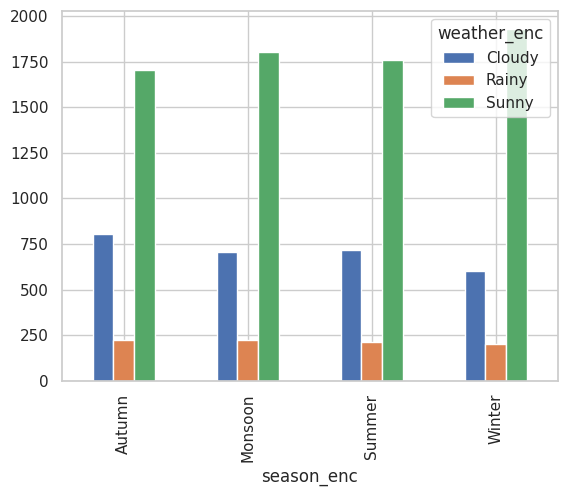

In [53]:
contigency.plot(kind='bar')

#### **Step 3:** Decide the significance level

The significance level (α) is already set to 5% i.e., 0.05

#### **Step 4:** Calculate the p-value

In [54]:
chi2, pval, dof, exp_freq = chi2_contingency(contigency, correction=False)
print('Chi-square Statistic: {} \n P-value: {} \n Degree of Freedom: {} \n Expected Frequencies: {}'.format(chi2, pval, dof, exp_freq))

Chi-square Statistic: 46.10145731073249 
 P-value: 2.8260014509929343e-08 
 Degree of Freedom: 6 
 Expected Frequencies: [[ 711.81956821  215.75617823 1806.42425356]
 [ 711.55920992  215.67726229 1805.76352779]
 [ 699.06201194  211.8892972  1774.04869086]
 [ 711.55920992  215.67726229 1805.76352779]]


In [55]:
result(pval, alpha)

As the p-value 2.8260014509929343e-08 is less than the level of significance, we reject the null hypothesis.


**Observation:** Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the weather conditions are dependent on the ongoing season.

### Insights and Recommendations

#### **EDA based insights -**

1. Total 10,886 rows were present in the data set.
2. Neither missing values, nor duplicate rows were found.
3. 'temp' and 'atemp' columns were found to be highly correlated. </br> Dropping one of them (atemp) to avoid multicollinearity.
4. 'count', 'casual' and 'registered' columns were highly correlated. </br> Dropping casual & registered columns to avoid multicollinearity.
5. Outlier values were found in the 'count' column.

#### **Insights from hypothesis testing -**
1. The no. of bikes rented on weekdays is comparatively higher than on weekends.
2. The no. of bikes rented on regular days is comparatively higher than on holidays.
2. The demand of bicycles on rent differs under different weather conditions.
3. The demand of bicycles on rent is different during different seasons.
4. The weather conditions are surely dependent upon the ongoing season.

#### **Miscellaneous observations -**
The distribution of 'count' column wasn't actually normal or near normal. </br> Infact the column's distribution is found to be a bit skewed towards right.

#### **Generic recommendations -**

* The demand of bikes on rent are usually higher during Weekdays.
* The demand of bikes on rent are usually higher during Regular days.
* The chances of person renting a bike are usually higher during Season 3.
* The chances of person renting a bike are usually higher during Weather condition 1.

We recommend the company to maintain the bike stocks accordingly.

